In [ ]:
    # Import libraries
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, ShuffleSplit, train_test_split
from sklearn.metrics import fbeta_score, accuracy_score, precision_score, roc_auc_score
from sklearn.utils import resample

# =============================
# Load Vaiciukynas data with emobase features 
# =============================

In [42]:
data = pd.read_csv('path_to/SP/phonation/SP_phonation_emobase.csv')
print("Size of data_meas : {}" .format(data.shape) )
data.head()

Size of data_meas : (297, 991)


,id,frameTime,pcm_intensity_sma_max,pcm_intensity_sma_min,pcm_intensity_sma_range,pcm_intensity_sma_maxPos,pcm_intensity_sma_minPos,pcm_intensity_sma_amean,pcm_intensity_sma_linregc1,pcm_intensity_sma_linregc2,...,F0env_sma_de_stddev,F0env_sma_de_skewness,F0env_sma_de_kurtosis,F0env_sma_de_quartile1,F0env_sma_de_quartile2,F0env_sma_de_quartile3,F0env_sma_de_iqr1_2,F0env_sma_de_iqr2_3,F0env_sma_de_iqr1_3,class
0,1,0,0.000022,5.031500e-09,0.000022,527,0,3.918500e-06,4.504600e-10,3.767200e-06,...,1.9755,8.8361,92.277,-0.279980,0.011072,0.28742,0.291050,0.27635,0.56740,1
1,1,0,0.000060,1.573300e-11,0.000060,741,0,1.269000e-05,1.311200e-09,1.215100e-05,...,1.7645,9.8987,114.670,-0.198900,0.025148,0.25234,0.224040,0.22719,0.45123,1
2,1,0,0.000046,7.553400e-12,0.000046,407,0,1.007600e-05,1.440300e-09,9.499400e-06,...,1.9301,10.6800,133.650,-0.212720,-0.025259,0.21595,0.187460,0.24121,0.42867,1
3,2,0,0.000003,2.479500e-09,0.000003,50,528,4.205900e-07,-6.909100e-10,6.523900e-07,...,1.4617,10.9110,131.380,-0.066048,0.032721,0.13463,0.098769,0.10191,0.20068,1
4,2,0,0.000001,3.151800e-09,0.000001,75,1,2.077600e-07,-2.152100e-11,2.160900e-07,...,1.6535,11.5240,145.130,-0.082307,0.010542,0.10683,0.092849,0.09629,0.18914,1


In [43]:
meta = pd.read_csv('path_to/pone.0185613.s003/DB.csv')
print("Size of data meta : {}" .format(meta.shape) )
meta = meta.drop(['class'], axis=1)
meta.head()

Size of data meta : (99, 4)


,id,Sex,Age
0,1,Male,49
1,2,Male,23
2,3,Female,22
3,4,Female,22
4,5,Female,31


In [45]:
df = pd.merge(data, meta, on='id')
df = df.rename(columns={'class': 'y'})
df.y = df['y'].map({1: 0,2: 1})

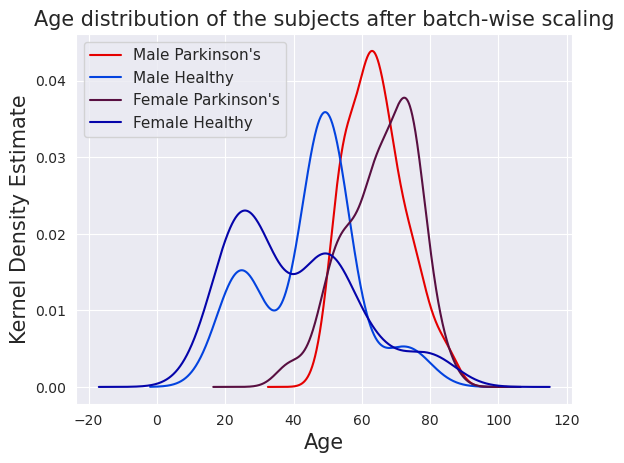

In [46]:
df_m_hc = df[(df.y == 0) & (df['Sex']=='Male')]
df_m_pd = df[(df.y == 1) & (df['Sex']=='Male')]
df_f_hc = df[(df.y == 0) & (df['Sex']=='Female')]
df_f_pd = df[(df.y == 1) & (df['Sex']=='Female')]
df_m_pd['Age'].plot(kind='kde', color='xkcd:red', label='Male Parkinson\'s')
df_m_hc['Age'].plot(kind='kde', color='xkcd:blue', label='Male Healthy')
df_f_pd['Age'].plot(kind='kde', color='xkcd:plum', label='Female Parkinson\'s')
df_f_hc['Age'].plot(kind='kde', color='xkcd:royal blue', label='Female Healthy')

plt.xlabel("Age", fontsize=15)
plt.ylabel("Kernel Density Estimate", fontsize=15)
# plt.legend(prop={'weight':'bold'})
plt.legend(fontsize="11")
plt.title('Age distribution of the subjects after batch-wise scaling', fontsize=15)
plt.savefig("Age_distribution_Vaiciukynas.png")
plt.savefig("Age_distribution_Vaiciukynas.pdf")

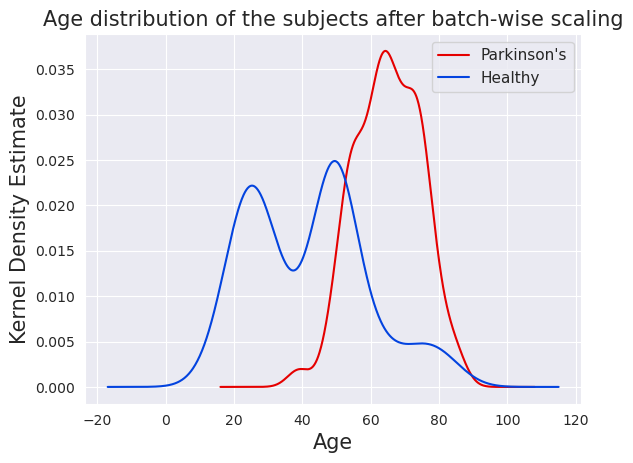

In [47]:
df_hc = df[df.y == 0]
df_pd = df[df.y == 1]

df_pd['Age'].plot(kind='kde', color='xkcd:red', label='Parkinson\'s')
df_hc['Age'].plot(kind='kde', color='xkcd:blue', label='Healthy')


plt.xlabel("Age", fontsize=15)
plt.ylabel("Kernel Density Estimate", fontsize=15)
# plt.legend(prop={'weight':'bold'})
plt.legend(fontsize="11")
plt.title('Age distribution of the subjects after batch-wise scaling', fontsize=15)
plt.savefig("Age_distribution_Vaiciukynas2.png")
plt.savefig("Age_distribution_Vaiciukynas2.pdf")

In [107]:
data = df.dropna()
# data = data[(data.Age >=25)&(data.Age <=75)]
data_hc = data[data.y ==0]
data_pd = data[data.y ==1]
print('data_hc: {}'.format(data_hc.shape))
print('data_pd: {}'.format(data_pd.shape))

data_hc = resample(data_hc,
                                    replace=True,
                                    n_samples=len(data_pd), # th = 0.15 5200 # th = 0.085 2000
                                    random_state=14)


data = pd.concat([data_pd, data_hc])


data_m = data[data['Sex'] == "Male"]
data_f = data[data['Sex'] == "Female"]
data_m_young = data_m[data_m.Age <= 40]
data_m_mid = data_m[(data_m.Age > 40) & (data_m.Age < 50)]
data_m_old = data_m[data_m.Age >= 50]

data_f_young = data_f[data_f.Age <= 40]
data_f_mid = data_f[(data_f.Age > 40) & (data_f.Age < 50)]
data_f_old = data_f[data_f.Age >= 50]


data_hc: (105, 993)
data_pd: (192, 993)


In [108]:
Y = data['y']
X = data.drop(['id', 'Age', 'Sex', 'y'], axis=1)
X_train, X_test, y_train, y_test, data_train, data_test = train_test_split(
    X, Y,data, test_size=0.30, random_state=14)
print('shape training set: {}'.format(X_train.shape))
print('shape test set: {}'.format(X_test.shape))

shape training set: (268, 989)
shape test set: (116, 989)


In [ ]:
# check xgboost version
from xgboost import XGBClassifier
model = XGBClassifier()
cv = ShuffleSplit(n_splits=2, test_size=0.25, random_state=0)
model.fit(X_train, y_train)

score_model_train = model.score(X_train, y_train)
print('Accuracy of model on train data: {:.4f}'.format(score_model_train))

scores_model_val = cross_val_score(model, X_train, y_train, cv=cv)
print("Accuracy model on cross validation: %0.4f ( %0.2f)" % (scores_model_val.mean(), scores_model_val.std()))

score_model_test = model.score(X_test, y_test)
print('Accuracy of model on test data: {:.4f}'.format(score_model_test))

In [ ]:
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
print('Accuracy of XGB classifier on training set: {:.4f}'.format(model.score(X_train, y_train)))
scores_xgb = cross_val_score(model, X_train, y_train,cv=cv)
print('\n')
print("Accuracy cv XGBoost all train data: %0.4f ( %0.2f)" % (scores_xgb.mean(), scores_xgb.std()))

scores_xgb = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall')
print("Sensitivity cv XGBoost all train data: %0.4f ( %0.2f)" % (scores_xgb.mean(), scores_xgb.std()))

scores_xgb = cross_val_score(model, X_train, y_train,  cv=cv, scoring='precision')
print("Precision cv XGBoost all train data: %0.4f ( %0.2f)" % (scores_xgb.mean(), scores_xgb.std()))

scores_xgb = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
print("AUC cv XGBoost all train data: %0.4f ( %0.2f)" % (scores_xgb.mean(), scores_xgb.std()))
specificity = make_scorer(recall_score, pos_label=0)
spe = cross_val_score(model, X_train, y_train, cv=cv, scoring=specificity)
print("Specificity cv XGBoost all train data: %0.4f ( %0.2f)" % (spe.mean(), spe.std()))

print('\n')
# all test data
t = 0.5
y_pred = model.predict(X_test)

print('F1: ', fbeta_score(y_test, y_pred, beta=1))
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('roc_auc: ', roc_auc_score(y_test, y_pred))
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
print('specificity: ', specificity)

In [116]:
# split train test
from sklearn.model_selection import train_test_split

Y_m_young = data_m_young['y']
X_m_young = data_m_young.drop(['id', 'Age', 'Sex', 'y'], axis=1)
X_train_m_young, X_test_m_young, y_train_m_young, y_test_m_young = train_test_split(
    X_m_young, Y_m_young, test_size=0.25, random_state=0)
print('shape training set: {}'.format(X_train_m_young.shape))
print('shape test set: {}'.format(X_test_m_young.shape))


Y_m_mid = data_m_mid['y']
X_m_mid = data_m_mid.drop(['id', 'Age', 'Sex', 'y'], axis=1)
X_train_m_mid, X_test_m_mid, y_train_m_mid, y_test_m_mid = train_test_split(
    X_m_mid, Y_m_mid, test_size=0.25, random_state=0)
print('shape training set: {}'.format(X_train_m_mid.shape))
print('shape test set: {}'.format(X_test_m_mid.shape))


Y_m_old = data_m_old['y']
X_m_old = data_m_old.drop(['id', 'Age', 'Sex', 'y'], axis=1)
X_train_m_old, X_test_m_old, y_train_m_old, y_test_m_old = train_test_split(
    X_m_old, Y_m_old, test_size=0.25, random_state=0)
print('shape training set: {}'.format(X_train_m_old.shape))
print('shape test set: {}'.format(X_test_m_old.shape))

Y_f_young = data_f_young['y']
X_f_young = data_f_young.drop(['id', 'Age', 'Sex', 'y'], axis=1)
X_train_f_young, X_test_f_young, y_train_f_young, y_test_f_young = train_test_split(
    X_f_young, Y_f_young, test_size=0.25, random_state=0)
print('shape training set: {}'.format(X_train_f_young.shape))
print('shape test set: {}'.format(X_test_f_young.shape))


Y_f_mid = data_f_mid['y']
X_f_mid = data_f_mid.drop(['id', 'Age', 'Sex', 'y'], axis=1)
X_train_f_mid, X_test_f_mid, y_train_f_mid, y_test_f_mid = train_test_split(
    X_f_mid, Y_f_mid, test_size=0.25, random_state=0)
print('shape training set: {}'.format(X_train_f_mid.shape))
print('shape test set: {}'.format(X_test_f_mid.shape))


Y_f_old = data_f_old['y']
X_f_old = data_f_old.drop(['id', 'Age', 'Sex', 'y'], axis=1)
X_train_f_old, X_test_f_old, y_train_f_old, y_test_f_old = train_test_split(
    X_f_old, Y_f_old, test_size=0.25, random_state=0)
print('shape training set: {}'.format(X_train_f_old.shape))
print('shape test set: {}'.format(X_test_f_old.shape))

shape training set: (18, 989)
shape test set: (6, 989)
shape training set: (19, 989)
shape test set: (7, 989)
shape training set: (76, 989)
shape test set: (26, 989)
shape training set: (60, 989)
shape test set: (20, 989)
shape training set: (13, 989)
shape test set: (5, 989)
shape training set: (100, 989)
shape test set: (34, 989)


In [117]:
# mpow young
scaler_m_young = preprocessing.RobustScaler(quantile_range=(25, 75))
x_trn = X_train_m_young.values #returns a numpy array
x_scaledtrn = scaler_m_young.fit_transform(x_trn)
X_train_m_young = pd.DataFrame(x_scaledtrn,index=X_train_m_young.index, columns=X_train_m_young.columns)

# mpow mid
scaler_m_mid = preprocessing.RobustScaler(quantile_range=(25, 75))
x_trn = X_train_m_mid.values #returns a numpy array
x_scaledtrn = scaler_m_mid.fit_transform(x_trn)
X_train_m_mid = pd.DataFrame(x_scaledtrn,index=X_train_m_mid.index, columns=X_train_m_mid.columns)

# mpow old
scaler_m_old = preprocessing.RobustScaler(quantile_range=(25, 75))
x_trn = X_train_m_old.values #returns a numpy array
x_scaledtrn = scaler_m_old.fit_transform(x_trn)
X_train_m_old = pd.DataFrame(x_scaledtrn,index=X_train_m_old.index, columns=X_train_m_old.columns)

# mpow young
scaler_f_young = preprocessing.RobustScaler(quantile_range=(25, 75))
x_trn = X_train_f_young.values #returns a numpy array
x_scaledtrn = scaler_f_young.fit_transform(x_trn)
X_train_f_young = pd.DataFrame(x_scaledtrn,index=X_train_f_young.index, columns=X_train_f_young.columns)

# mpow mid
scaler_f_mid = preprocessing.RobustScaler(quantile_range=(25, 75))
x_trn = X_train_f_mid.values #returns a numpy array
x_scaledtrn = scaler_f_mid.fit_transform(x_trn)
X_train_f_mid = pd.DataFrame(x_scaledtrn,index=X_train_f_mid.index, columns=X_train_f_mid.columns)

# mpow old
scaler_f_old = preprocessing.RobustScaler(quantile_range=(25, 75))
x_trn = X_train_f_old.values #returns a numpy array
x_scaledtrn = scaler_f_old.fit_transform(x_trn)
X_train_f_old = pd.DataFrame(x_scaledtrn,index=X_train_f_old.index, columns=X_train_f_old.columns)

#test
# mpow young
x_trn = X_test_m_young.values #returns a numpy array
x_scaledtrn = scaler_m_young.transform(x_trn)
X_test_m_young = pd.DataFrame(x_scaledtrn,index=X_test_m_young.index, columns=X_test_m_young.columns)

# mpow mid
x_trn = X_test_m_mid.values #returns a numpy array
x_scaledtrn = scaler_m_mid.transform(x_trn)
X_test_m_mid = pd.DataFrame(x_scaledtrn,index=X_test_m_mid.index, columns=X_test_m_mid.columns)

# mpow old
x_trn = X_test_m_old.values #returns a numpy array
x_scaledtrn = scaler_m_old.transform(x_trn)
X_test_m_old = pd.DataFrame(x_scaledtrn,index=X_test_m_old.index, columns=X_test_m_old.columns)

#test
# mpow young
x_trn = X_test_f_young.values #returns a numpy array
x_scaledtrn = scaler_f_young.transform(x_trn)
X_test_f_young = pd.DataFrame(x_scaledtrn,index=X_test_f_young.index, columns=X_test_f_young.columns)

# mpow mid
x_trn = X_test_f_mid.values #returns a numpy array
x_scaledtrn = scaler_f_mid.transform(x_trn)
X_test_f_mid = pd.DataFrame(x_scaledtrn,index=X_test_f_mid.index, columns=X_test_f_mid.columns)

# mpow old
x_trn = X_test_f_old.values #returns a numpy array
x_scaledtrn = scaler_f_old.transform(x_trn)
X_test_f_old = pd.DataFrame(x_scaledtrn,index=X_test_f_old.index, columns=X_test_f_old.columns)

In [118]:
X_train = pd.concat([X_train_m_young,X_train_m_mid, X_train_m_old,X_train_f_young, X_train_f_mid, X_train_f_old])
X_test = pd.concat([X_test_m_young, X_test_m_mid, X_test_m_old,X_test_f_young, X_test_f_mid, X_test_f_old])
y_train = pd.concat([y_train_m_young, y_train_m_mid, y_train_m_old,y_train_f_young, y_train_f_mid, y_train_f_old])
y_test = pd.concat([y_test_m_young, y_test_m_mid, y_test_m_old,y_test_f_young, y_test_f_mid, y_test_f_old])

In [ ]:
model.fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.4f}'.format(model.score(X_train, y_train)))
scores_xgb = cross_val_score(model, X_train, y_train,cv=cv)
print('\n')
print("Accuracy cv XGBoost all train data: %0.4f ( %0.2f)" % (scores_xgb.mean(), scores_xgb.std()))

scores_xgb = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall')
print("Sensitivity cv XGBoost all train data: %0.4f ( %0.2f)" % (scores_xgb.mean(), scores_xgb.std()))

scores_xgb = cross_val_score(model, X_train, y_train,  cv=cv, scoring='precision')
print("Precision cv XGBoost all train data: %0.4f ( %0.2f)" % (scores_xgb.mean(), scores_xgb.std()))

scores_xgb = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
print("AUC cv XGBoost all train data: %0.4f ( %0.2f)" % (scores_xgb.mean(), scores_xgb.std()))
specificity = make_scorer(recall_score, pos_label=0)
spe = cross_val_score(model, X_train, y_train, cv=cv, scoring=specificity)
print("Specificity cv XGBoost all train data: %0.4f ( %0.2f)" % (spe.mean(), spe.std()))

print('\n')
# all test data
t = 0.5
y_pred = model.predict(X_test)

print('F1: ', fbeta_score(y_test, y_pred, beta=1))
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('roc_auc: ', roc_auc_score(y_test, y_pred))
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
print('specificity: ', specificity)

In [120]:
from sklearn.feature_selection import RFECV
min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=model,
    step=1,
    cv=cv,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv.fit(X_train, y_train)
print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 41


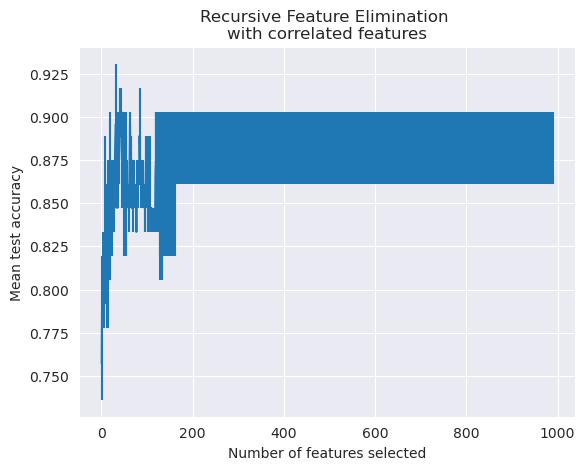

In [121]:
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.savefig("RecursiveFeatureEliminationemobase_SP.png")
plt.savefig("RecursiveFeatureEliminationemobase_SP.pdf")
plt.show()

In [122]:
mask = rfecv.get_support()
features = X.columns
best_features = features[mask]
print(best_features)

Index(['pcm_intensity_sma_min', 'pcm_fftMag_mfcc_sma_1__iqr2_3',
       'pcm_fftMag_mfcc_sma_2__min', 'pcm_fftMag_mfcc_sma_2__quartile3',
       'pcm_fftMag_mfcc_sma_2__iqr2_3', 'pcm_fftMag_mfcc_sma_3__quartile1',
       'pcm_fftMag_mfcc_sma_5__quartile3', 'pcm_fftMag_mfcc_sma_7__iqr2_3',
       'pcm_fftMag_mfcc_sma_9__max', 'pcm_fftMag_mfcc_sma_9__min',
       'pcm_fftMag_mfcc_sma_9__linregc2', 'pcm_fftMag_mfcc_sma_9__kurtosis',
       'pcm_fftMag_mfcc_sma_11__maxPos', 'pcm_fftMag_mfcc_sma_11__minPos',
       'lspFreq_sma_1__range', 'lspFreq_sma_2__kurtosis',
       'lspFreq_sma_2__quartile2', 'lspFreq_sma_5__minPos',
       'lspFreq_sma_6__linregc1', 'lspFreq_sma_6__quartile3',
       'lspFreq_sma_7__minPos', 'voiceProb_sma_maxPos', 'voiceProb_sma_minPos',
       'F0_sma_maxPos', 'F0_sma_iqr2_3', 'F0env_sma_maxPos',
       'F0env_sma_linregerrQ', 'pcm_fftMag_mfcc_sma_de_1__linregerrQ',
       'pcm_fftMag_mfcc_sma_de_3__max', 'pcm_fftMag_mfcc_sma_de_4__kurtosis',
       'pcm_fftMag_mf

In [ ]:
X_train2 = X_train[best_features]
modelxgb_s = XGBClassifier(eval_metric='mlogloss')
# XGBoost
modelxgb_s.fit(X_train2, y_train)

modelxgb_s.fit(X_train2, y_train)

print('Accuracy of XGB classifier on training set: {:.4f}'.format(modelxgb_s.score(X_train2, y_train)))
scores_xgb = cross_val_score(modelxgb_s, X_train2, y_train,cv=cv)
print('\n')
print("Accuracy cv XGBoost all train data: %0.4f ( %0.2f)" % (scores_xgb.mean(), scores_xgb.std()))

scores_xgb = cross_val_score(modelxgb_s, X_train2, y_train, cv=cv, scoring='recall')
print("Sensitivity cv XGBoost all train data: %0.4f ( %0.2f)" % (scores_xgb.mean(), scores_xgb.std()))

scores_xgb = cross_val_score(modelxgb_s, X_train2, y_train,  cv=cv, scoring='precision')
print("Precision cv XGBoost all train data: %0.4f ( %0.2f)" % (scores_xgb.mean(), scores_xgb.std()))

scores_xgb = cross_val_score(modelxgb_s, X_train2, y_train, cv=cv, scoring='roc_auc')
print("AUC cv XGBoost all train data: %0.4f ( %0.2f)" % (scores_xgb.mean(), scores_xgb.std()))
specificity = make_scorer(recall_score, pos_label=0)
spe = cross_val_score(modelxgb_s, X_train2, y_train, cv=cv, scoring=specificity)
print("Specificity cv XGBoost all train data: %0.4f ( %0.2f)" % (spe.mean(), spe.std()))

print('\n')
# all test data
t = 0.5
X_test2 = X_test[best_features]
y_pred = modelxgb_s.predict(X_test2)

print('F1: ', fbeta_score(y_test, y_pred, beta=1))
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('roc_auc: ', roc_auc_score(y_test, y_pred))
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
print('specificity: ', specificity)